# L4c: K-Nearest Neighbor (KNN) Classification
In this lecture, we'll look at [K-nearest neighbor classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) and its kernelized variant, which is an _unsupervised_ approach to solve (binary) classification problems. The key ideas of this lecture are:
* __K-nearest neighbor classification__: Developed by [Fix and Hodges in 1951](https://www.jstor.org/stable/1403797?socuuid=e7bcd649-778e-473f-8b7b-92805b5fab5f) is an _unsupervised_ classification algorithm where an object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its $k$-nearest neighbors, where $k>0$ is typically _small_. Traditionally, distance in a KNN is measured as [the Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance)
* __Kernelized K-nearest neighbor classification__: is a variation of the standard [KNN algorithm](https://www.jstor.org/stable/1403797?socuuid=e7bcd649-778e-473f-8b7b-92805b5fab5f) that utilizes a kernel function to measure similarity between data points, allowing for more complex non-linear decision boundaries. Using a kernel, the algorithm can identify complex relationships between data points not easily captured by the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) measures, improving classification accuracy on non-linearly seperable datasets.
* __Kernel trick__: The [kernel trick](https://en.wikipedia.org/wiki/Kernel_trick) is a clever technique in machine learning that allows algorithms to operate in high-dimensional feature spaces without explicitly computing the coordinates in that space. _Its key assumption_: Our problem can be solved by being embedded in much higher dimensional spaces (perhaps even infinite dimensional spaces) but without having to do an infinite amount of work.

Lecture notes for today can be found: [here!](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-4/L4c/docs/Notes.pdf)

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl");

Next, let's set some constants we'll need for the data generation logic below. Please look at the comment next to the constant for a description of what it is, permissible values, etc.

In [5]:
number_label_one = 1000; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 1000; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a generated label; see below.
c̄₁ = (0.0, 0.0); # center for the cloud: fixed
θ = 60*(π/180); # rotation angle (radians)

Finally, let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary class labels, i.e., $ y\in\{1,-1\}$ while the values are the colors mapped to that label.

In [7]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1

### Data
We'll use [K-nearest neighbor classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to classify datasets, including [the XOR dataset](https://en.wikipedia.org/wiki/Exclusive_or) that we construct. First, we'll generate a master dataset (which may or may not be linearly separable), then split it into (random) `training` and `test` subsets.
* __Training data__: Training datasets are collections of labeled data used to teach machine learning models, allowing these tools to learn patterns and relationships within the data. In our case, we'll use the training data to estimate the classifier parameters $\beta$.
* __Test data__: Test datasets, on the other hand, are separate sets of labeled data used to evaluate the performance of trained models on unseen examples, providing an unbiased assessment of the _model's generalization capabilities_.

Let's start with the master dataset `D::Array{Float64,2}`. This dataset will have two continuous features $\mathbf{x}\in\mathbb{R}^{2}$ and a categorical label $y\in\{-1,1\}$. We'll build a label function $L:\mathbb{R}\times\mathbb{R}\to\{\text{true, false}\}$ (we can change this function around to get different labeling patterns):

In [9]:
# TODO: uncomment this logic for different labeling patterns
L(x,y) = (y ≥ 0) ? true : false; # rotated half circle (linearly separable)
# L(x,y) = (x ≥ 0) && (y ≥ 0) ? true : false; # wedge pattern (not linearly separable)
# L(x,y) = xor(x ≥ 0,y ≥ 0); # XOR pattern alternating pie wedges (not linearly separable)
# L(x,y) = xor(rand() ≥ 0.5,rand() ≥ 0.5); # random
# L(x,y) = (rand() ≥ 0.5) ? true : false; # rotated half circle (linearly separable)

Generate the master dataset `D`:

In [11]:
D = let
    
    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=1, radius = 1.0); # generate label 1 data
    s₂ = generatedatacloud(c̄₁, number_of_points = number_label_two, label=-1, radius = 2.0); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end

    # compute the label by taking the XOR, OR, AND, etc functions
    for i ∈ 1:total_number_of_points
        flag = L(D[i,1],D[i,2]);
        if (flag == true)
            D[i,3] = 1
        else
            D[i,3] = -1
        end
    end

    # finally, let's rotate the data a bit (counter-clockwise)
    R = [
        cos(θ) -sin(θ) ;
        sin(θ) cos(θ) ;
    ];

    # keep the label, but apply the rotation the (x,y) data
    D̂ = copy(D);
    for i ∈ 1:total_number_of_points
        x̂ = R*D[i,1:2];
        D̂[i,1] = x̂[1];
        D̂[i,2] = x̂[2];
    end
    
    D̂ # return the data
end;

#### Visualize dataset `D`
`Unhide` the code block below to see how we plotted the dataset `D` which contains two continuous features and a label. The color indicates the label.
* __Summary__: We will get a different pattern of $\pm{1}$ labels depending on the labeling function logic $L(x_{1},x_{2})$ we used. The dark blue dots represent label `1`, while the orange data represents label `1`. Our 
classifier should be able to learn the mapping between the features and the labels for linearly separable datasets.

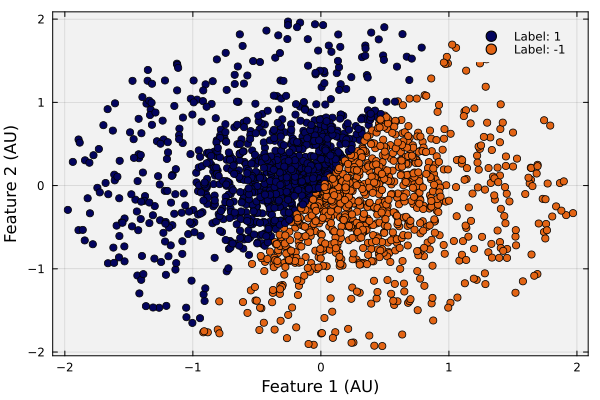

In [13]:
let

    dataset = D; # what dataset am I looking at?
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot

    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot all points
    for i ∈ 1:total_number_of_points
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

Next, let's split that dataset `D` into `training` and `test` subsets. We do this randomly, where the `number_of_training_examples::Int64` variable specifies the number of training points. The `training::Array{Float64,2}` data will be used to estimate the model parameters, and `test::Array{Float64,2}` will be used for model testing.

In [15]:
training, test = let

    number_of_training_examples = 1200; # we make this number of
    number_of_examples = total_number_of_points;
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D[training_index_set |> collect,:];
    test = D[test_index_set |> collect,:];

    # return
    training, test
end;

## K-Nearest Neighbor Classification
K-nearest neighbor (KNN) classification is a simple yet powerful machine learning algorithm for classification and regression tasks. The algorithm finds the K closest data points to a new instance in the feature space and then classifies the new instance based on the majority class among these neighbors.

* __Key assumption__: The key assumption of a [K-nearest neighbor classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) is that _similar_ inputs have _similar_ labels (in classification tasks) or _similar_ outputs for K-nearest neighbor regression tasks. However, the wiggly aspect of this assumption is what we mean by _similar_.

__Algorithm__
* __Initialization__. You provide some _reference_ dataset $\mathcal{D} = \{(\mathbf{x}_{i},y_{i}) \mid i = 1,2,\dots,n\}$, where the vectors $\mathbf{x}_i \in \mathbb{R}^{m}$ are $m$-dimensional feature vectors ($m\ll{n}$) and the target variables are discrete labels $y_i \in \left\{-1,1\right\}$. We'll use the reference dataset $\mathcal{D}$ to compare our unknown points.
* __Inference__: The distance (similarity) between a test feature vector $\mathbf{z}$ and _all reference instances_ is computed; call this set $\mathcal{S}$. Set $\mathcal{S}$ is sorted from highest to lowest similarity. Then, a particular label is estimated from the labels of the top-K elements of the sorted neighbor set —- _decision rule_: Majority wins (but we could imagine other scenarios).

We've implemented a KNN classifier in this repo. In the code block below, we:
* Construct [a `MyKNNClassificationModel` model](src/Types.jl) using a [custom `build(...)` method](src/Factory.jl). The `model` instance holds all the data for the problem, i.e., the how many neighbours to look at `K`, and the similarity function $d$.
* Next, we pass this `model` instance to [the `classify(...)` method](src/Compute.jl) which takes a test feature $\mathbf{z}$, the reference feature matrix $\mathbf{X}$ and label vector $\mathbf{y}$, and the classifier `model` instance and returns the predicted label value $\hat{y}$ for the test feature vector $\mathbf{z}$.
* We return the predicted label in the `ŷ_KNN::Array{Int64,1}` array, and the actual label in the `y_KNN::Array{Int64,1}` array.

In [17]:
ŷ_KNN,y_KNN = let

    # setup kernel -
    γ = 1.0; # pick a scale parameter
    # k = SqExponentialKernel() ∘ ScaleTransform(γ);
    # k = LinearKernel()
    # k = ExponentiatedKernel();
    # k = Matern32Kernel();
    # k = FBMKernel(h = 0.7);

    # Data -
    D₁ = training; # reference dataset 
    D₂ = test; # test
    number_of_training_examples = size(training,1);
    number_of_test_examples = size(test,1);
    X₁ = D₁[:,1:end-1]; # data for training (notice no extra 1)
    y₁ = D₁[:,end]; # label for training
    X₂ = D₂[:,1:end-1]; # data for test (notice no extra 1)
    y₂ = D₂[:,end]; # label for test
    ŷ₂ = zeros(number_of_test_examples);  # initialize some storage for the predicted label

    # build a model -
    model = build(MyKNNClassificationModel, (
        K = 100,
        d = (x,y) -> -1*norm(x-y)^2 # some distance or similarity metric (replace with (x,y) -> k(x,y) for a kernel)
    ));

    # process each vector in the test set, and compare that to training (reference)
    for i ∈ 1:number_of_test_examples
        z = X₂[i,:]; # get feature vector for test
        ŷ₂[i] = classify(z,X₁,y₁,model) # classify the test vector using the training data
    end
 
    # return -
    ŷ₂,y₂
end;

### Performance 

We can evaluate the binary classifier's performance using various metrics. The central idea is to compare the predicted labels $\hat{y}_{i}$ to the actual labels $y_{i}$ in the `test` dataset and measure wins (when the label is the same) and losses (label is different). This is easily represented in [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
* We compute confusion matrix [using the `confusion(...)` method](src/Compute.jl) and store it in the `CM_KNN::Array{Int64,2}` variable. The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [19]:
CM_KNN = confusion(y_KNN,ŷ_KNN)

2×2 Matrix{Int64}:
   9  387
 388   16

Finally, we can compute the overall error rate for the perceptron (or other performance metrics) using values from [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [21]:
number_of_test_points = length(y_KNN);
correct_prediction_perceptron = CM_KNN[1,1] + CM_KNN[2,2];
(correct_prediction_perceptron/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

Fraction correct: 0.03125 Fraction incorrect 0.96875


### Visualize the misses

Using the test dataset, let's show (with white circles) which samples our classifier cannot predict the label correctly, i.e., where we miss the label. `Unhide` the code block below to see how we plotted the misclassified data points for the `test` dataset.

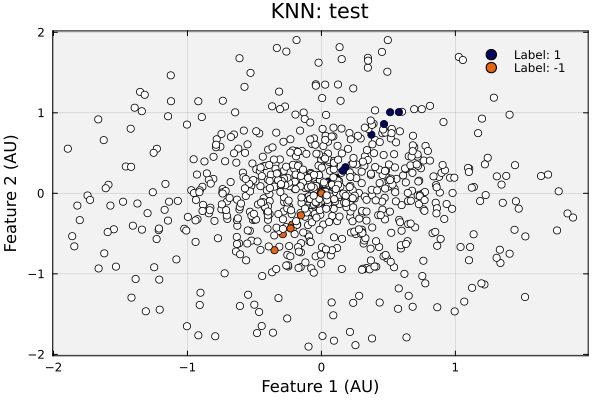

In [23]:
let

    dataset = test; # what dataset am I looking at?
    caselabel = "test";
    actual = y_KNN;
    predicted = ŷ_KNN;
    number_of_points = size(dataset,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # data -
    for i ∈ 1:number_of_points
        actuallabel = actual[i]; # actual label
        testlabel = predicted[i]; # predited label

        c = :white;
        if (actuallabel == testlabel)
            c = my_color_dictionary[actuallabel]
        end
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end

    title!("KNN: $(caselabel)", fontsize=18)
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

## The Kernel Trick
The kernel trick is a clever technique in machine learning that allows algorithms to operate in high-dimensional feature spaces without explicitly computing the coordinates in that space. It enables linear classifiers to solve nonlinear problems by implicitly mapping data into a higher-dimensional space, making complex pattern analysis more computationally efficient.

* __Mapping to higher dimensions__? We can take a feature vector $\mathbf{x}\in\mathbb{R}^{n}$ and combine its elements to make a higher dimensional object with $m$ components ($m>n$) using a feature map. For example, suppose we wanted to go from a scalar to a four-dimensional object. In this case, we could propose a feature map $\phi:\mathbb{R}\to\mathbb{R}^{4}$, such that $\phi(x) = \left(1,x,x^{2}, x^{3}\right)^{\top}$. In the language of models, this is still a linear model because we can write something like: $y = \phi\left(x\right)^{\top}\theta$, where $\theta\in\mathbb{R}^{4}$ is an (unknown) parameter vector.
* __Another meaning of kernel functions__: We know that the inner product $k(\mathbf{x},\mathbf{z}) = \left<\mathbf{x},\mathbf{z}\right>$ is a valid kernel function. However, the function $k(\mathbf{x},\mathbf{z}) = \left<\phi(\mathbf{x}),\phi(\mathbf{z})\right>$ is also a kernel function, i.e., we have applied some feature map $\phi: \mathbb{R}^{\star}\to\mathbb{R}^{\dagger}$ where $\dagger>\star$ to our input feature vectors and taken the inner product of the $\dagger$-dimensional objects. Ok, but what is the feature map $\phi$? How do I choose this? Perhaps if you have some insight, you could choose $\phi$. 
* __TLDR: You don't have to choose a feature mapping $\phi$__! By choosing a (valid) functional form for the kernel $k$, you indirectly assume a feature map $\phi$. Thus, in a problem, when you iterate over functional forms for the $k$ function, each gives a new feature mapping. Everything else stays the same.

#### Example
Let's consider an example [taken from the IEOR E4525 course of Prof. Martin Haugh at Columbia](https://martin-haugh.github.io/teaching/ml-orfe/). Let the feature dimension $m = 2$. Then, a kernel function of the form: $k(\mathbf{x}_{i},\mathbf{x}_{j}) = \left<\mathbf{x}_{i},\mathbf{x}_{j}\right>^{2}$ encodes the implicit mapping: $\phi\left(\mathbf{x}\right) = \left(x_{1}^{2},\sqrt{2}x_{1}x_{2},x_{2}^{2}\right)$. This should be true for any two vectors $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$ we choose, thus, the Kernel matrix should have the entries $K_{ij} = \left<\mathbf{x}_{i},\mathbf{x}_{j}\right>^{2} = \left<\phi(\mathbf{x}_{i}),\phi(\mathbf{x}_{j})\right>$.

We'll start by computing the kernel matrix $\mathbf{K}$ with elements $K_{ij} = \left<\mathbf{x}_{i},\mathbf{x}_{j}\right>^{2}$. We'll save this in the `K₁::Array{Float64,2}` array:

In [25]:
K₁ = let

    D₂ = test;
    number_of_test_examples = size(D₂,1);
    X₂ = D₂[:,1:end-1]; # data for test (notice no extra 1)
    K = zeros(number_of_test_examples,number_of_test_examples);

    for i ∈ 1:number_of_test_examples
        vᵢ = X₂[i,:];
        for j ∈ 1:number_of_test_examples
            vⱼ = X₂[j,:];
            K[i,j] = dot(vᵢ,vⱼ)^2 # compute inner product squared
        end
    end
    
    K
end

800×800 Matrix{Float64}:
 2.25735e-6   4.72215e-5   6.2086e-5    …  0.0034312    0.000173851
 4.72215e-5   0.00102155   0.00233288      0.0622165    0.00204454
 6.2086e-5    0.00233288   0.104903        0.0140867    0.0776086
 1.69834e-6   3.4921e-5    3.20001e-5      0.00276503   0.00016605
 2.0871e-5    0.000693067  0.0222372       0.000110978  0.0129815
 0.000374414  0.0167873    1.09795      …  0.451534     0.989621
 2.89429e-5   0.00174624   0.179926        0.149813     0.193662
 6.65527e-5   0.000356504  0.145897        0.918238     0.353194
 3.19173e-8   8.42171e-8   0.000604244     0.00206361   0.00108712
 0.000252479  0.00734927   0.147566        0.0275905    0.0532424
 0.00205364   0.0497973    0.364484     …  1.47637      0.00278692
 3.99737e-5   0.00132734   0.0425809       0.000211539  0.0248542
 7.38542e-6   0.000131499  6.28017e-5      0.0194263    0.00261541
 ⋮                                      ⋱               
 4.4173e-6    0.000129548  0.00268249      0.000419893  

Next, we'll calculate the kernel matrix $\mathbf{K}$ with elements $K_{ij} = \left<\phi(\mathbf{x}_{i}),\phi(\mathbf{x}_{j})\right>$. We'll save this in the `K₂::Array{Float64,2}` array:

In [27]:
K₂ = let
    
    D₂ = test;
    number_of_test_examples = size(D₂,1);
    X₂ = D₂[:,1:end-1]; # data for test (notice no extra 1)
    K = zeros(number_of_test_examples,number_of_test_examples);

    for i ∈ 1:number_of_test_examples
        vᵢ = X₂[i,:];
        ϕᵢ = [vᵢ[1]^2,(√2)*vᵢ[1]*vᵢ[2],vᵢ[2]^2]; # explicitly compute mapping
        for j ∈ 1:number_of_test_examples
            vⱼ = X₂[j,:];
            ϕⱼ = [vⱼ[1]^2,(√2)*vⱼ[1]*vⱼ[2],vⱼ[2]^2]; # explicitly compute mapping
            K[i,j] = dot(ϕᵢ,ϕⱼ)
        end
    end
    
    K
end

800×800 Matrix{Float64}:
 2.25735e-6   4.72215e-5   6.2086e-5    …  0.0034312    0.000173851
 4.72215e-5   0.00102155   0.00233288      0.0622165    0.00204454
 6.2086e-5    0.00233288   0.104903        0.0140867    0.0776086
 1.69834e-6   3.4921e-5    3.20001e-5      0.00276503   0.00016605
 2.0871e-5    0.000693067  0.0222372       0.000110978  0.0129815
 0.000374414  0.0167873    1.09795      …  0.451534     0.989621
 2.89429e-5   0.00174624   0.179926        0.149813     0.193662
 6.65527e-5   0.000356504  0.145897        0.918238     0.353194
 3.19173e-8   8.42171e-8   0.000604244     0.00206361   0.00108712
 0.000252479  0.00734927   0.147566        0.0275905    0.0532424
 0.00205364   0.0497973    0.364484     …  1.47637      0.00278692
 3.99737e-5   0.00132734   0.0425809       0.000211539  0.0248542
 7.38542e-6   0.000131499  6.28017e-5      0.0194263    0.00261541
 ⋮                                      ⋱               
 4.4173e-6    0.000129548  0.00268249      0.000419893  

Does $\mathbf{K}_{1} = \mathbf{K}_{2}$, i.e., for any two vectors that we choose, does $\left<\mathbf{x}_{i},\mathbf{x}_{j}\right>^{2} = \left<\phi(\mathbf{x}_{i}),\phi(\mathbf{x}_{j})\right>$ for the feature map: $\phi\left(\mathbf{x}\right) = \left(x_{1}^{2},\sqrt{2}x_{1}x_{2},x_{2}^{2}\right)$?

In [29]:
K₁ ≈ K₂

true

# Today?
That's a wrap! What are some of the interesting things we discussed today?